#Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/AI/data_6'
data = ['test', 'train', 'train_cleaned']
batch_size = 64

#Pre processing

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import glob
from sklearn.model_selection import KFold

import shutil
import os

from torchvision import datasets
from torchvision.utils import save_image

In [ ]:
out_0 = os.listdir(path + '/' + data[0])
out_0.sort()
out_1 = os.listdir(path + '/' + data[1])
out_1.sort()
out_2 = os.listdir(path + '/' + data[2])
out_2.sort()

print(out_0)
print(out_1)
print(out_2)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
standar_size = (180,80)
import torchvision.transforms.functional as TF
from PIL import Image

test_set = []
for i in out_0:
  a = Image.open(path + '/' + data[0] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  test_set.append(x)

train_set = []
for i in out_1:
  a = Image.open(path + '/' + data[1] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  train_set.append(x)

train_cleaned_set = []
for i in out_2:
  a = Image.open(path + '/' + data[2] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  train_cleaned_set.append(x)

In [ ]:
type(test_set)

list

In [ ]:
#Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
train_clean_loader = torch.utils.data.DataLoader(dataset=train_cleaned_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

#Autoencoder MLP

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.f1 = nn.Sequential(
        nn.Linear(180*80,180*10),
        nn.ReLU()
    )

    self.f2 = nn.Sequential(
        nn.Linear(180*10,180*10),
        nn.ReLU()
    )

  def forward(self, image):
    out = self.f1(image) 
    z = self.f2(out)
    return z

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()

    self.f1 = nn.Sequential(
        nn.Linear(180*10,180*10),
        nn.ReLU()
    )

    self.f5 = nn.Sequential(
        nn.Linear(180*10,180*80),
    )

  def forward(self, z):
    out = self.f1(z)
    out = torch.tanh(self.f5(z))
    return out
 
class Autoncoder(nn.Module):
  def __init__(self):
    super(Autoncoder,self).__init__()
    self.encoder = Encoder()
    self.Decoder = Decoder()

  def forward(self, image):
    z = self.encoder(image)
    out =  self.Decoder(z)
    return out
  def reiniciar(self):
    super(Autoncoder,self).__init__()
    self.encoder = Encoder()
    self.Decoder = Decoder()


## Functions

In [ ]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out,10,5)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

Train

In [ ]:
from sklearn.utils import shuffle

def train(model, train_s, train_cleaned_s, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
      
      #for img in train_s:
      train_s, train_cleaned_s = shuffle(train_s, train_cleaned_s)
      for i in range(batch_size):
          img = train_s[i]
          img = img.view(img.size(0),-1)
          img = img.to(device)
          img_recon = model(img)
          img_clean = train_cleaned_s[i].view(train_cleaned_s[i].size(0),-1).to(device)
          loss = loss_fn(img_recon, img_clean)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
      if loss<0.013:
        break
    return train_loss_avg

K-fold

In [ ]:
def Kfold_t(model, train_s, train_cleaned_s, Epochs, loss_fn, optimizer, fold=10):
  kfold = KFold(n_splits=fold, shuffle=False)
  loss_array = []
  for fold, (train_ids, test_ids) in enumerate(kfold.split(range(len(train_s)))):
    model.reiniciar()
    model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

    num_batches_train = 0
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      for i in train_ids:
        img = train_s[i]
        img = img.view(img.size(0),-1)
        img = img.to(device)
        img_recon = model(img)
        img_clean = train_cleaned_s[i].view(train_cleaned_s[i].size(0),-1).to(device)
        loss = loss_fn(img_recon, img_clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches_train += 1
      train_loss_avg[-1] /= num_batches_train
      print('Fold: ', fold, 'Epoch: [',epoch+1, '/',Epochs,'] Loss:', train_loss_avg[-1])
    
    img_test = model(test_set[0].view(test_set[0].size(0),-1).to(device))
    img_test = img_test.reshape(80, -1)
    Show_Weight(img_test)

    test_loss_avg = []
    test_loss_avg.append(0)
    num_batches = 0
    for i in test_ids:
      img = train_s[i]
      img = img.view(img.size(0),-1)
      img = img.to(device)
      img_recon = model(img)
      img_clean = train_cleaned_s[i].view(train_cleaned_s[i].size(0),-1).to(device)
      loss = loss_fn(img_recon, img_clean)
      test_loss_avg[-1] += loss.item()
      num_batches += 1
      print('Test: [',i+1, '/',len(test_ids),'] Loss:', loss.item())
    # if loss < 0.005:
    #   break
    test_loss_avg[-1] /= num_batches
    loss_array.append(test_loss_avg[-1])
    print('         Fold: ', fold, 'Test avg Loss:', loss_array[-1])
    print(len(test_loss_avg))
  return loss_array


In [ ]:
def img_autoencoder(model, path_i):
  autoencoder = model.to(device)
  a = Image.open(path_i)
  a = a.resize(standar_size)
  a = a.convert('L')
  img = TF.to_tensor(a)
  img.unsqueeze_(0)
  img = img.to(device)
  Show_Weight(img)
  img_recon = autoencoder(img)
  img_recon = img_recon.to(device)
  Show_Weight(img_recon)
  return img_recon


Clean image / Original image

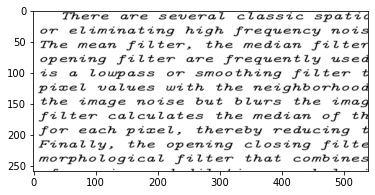

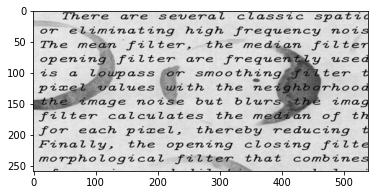

In [ ]:
img = train_cleaned_set[17]
Show_Weight(img)

img = train_set[17]
Show_Weight(img)

#Experimentation

###Train
Se hace train con todo el train data set

In [ ]:
learning_rate = 0.00001
autoencoder_p = Autoncoder()
autoencoder_p.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder_p.parameters(), lr=learning_rate)
autoencoder_p.train()
loss_values = train(autoencoder_p, train_set, train_cleaned_set, 50, loss)

Epoch [1 / 50] average reconstruction error: 0.486526
Epoch [2 / 50] average reconstruction error: 0.047745
Epoch [3 / 50] average reconstruction error: 0.028360
Epoch [4 / 50] average reconstruction error: 0.025867
Epoch [5 / 50] average reconstruction error: 0.025178
Epoch [6 / 50] average reconstruction error: 0.025210
Epoch [7 / 50] average reconstruction error: 0.025456
Epoch [8 / 50] average reconstruction error: 0.025657
Epoch [9 / 50] average reconstruction error: 0.024676
Epoch [10 / 50] average reconstruction error: 0.025805
Epoch [11 / 50] average reconstruction error: 0.024862
Epoch [12 / 50] average reconstruction error: 0.025167
Epoch [13 / 50] average reconstruction error: 0.024678
Epoch [14 / 50] average reconstruction error: 0.024496
Epoch [15 / 50] average reconstruction error: 0.024841
Epoch [16 / 50] average reconstruction error: 0.024725
Epoch [17 / 50] average reconstruction error: 0.023859
Epoch [18 / 50] average reconstruction error: 0.023973
Epoch [19 / 50] ave

Error per epochs

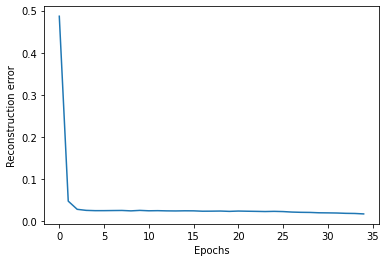

In [ ]:
fig = plt.figure()
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Results

1
torch.Size([1, 14400])


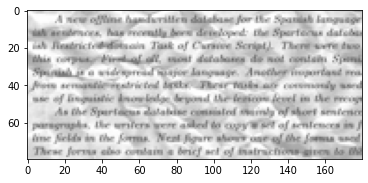

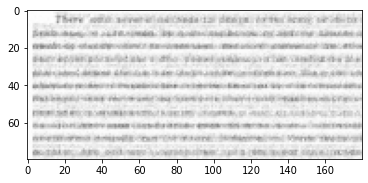

In [ ]:
#autoencoder = Autoncoder()
autoencoder_p = autoencoder_p.to(device)
img = test_set[1]
print(img.size(1))
img = img.reshape(1, -1).to(device)
print(img.shape)
img_recon = autoencoder_p(img)
img = img.reshape(80, -1)
img_recon = img_recon.reshape(80, -1)
Show_Weight(img)
Show_Weight(img_recon)

Fold:  0 Epoch: [ 1 / 20 ] Loss: 0.07250107253013655
Fold:  0 Epoch: [ 2 / 20 ] Loss: 0.0181543206391755
Fold:  0 Epoch: [ 3 / 20 ] Loss: 0.008038612636099798
Fold:  0 Epoch: [ 4 / 20 ] Loss: 0.0058234591369134515
Fold:  0 Epoch: [ 5 / 20 ] Loss: 0.004909848377050817
Fold:  0 Epoch: [ 6 / 20 ] Loss: 0.0040386447127071
Fold:  0 Epoch: [ 7 / 20 ] Loss: 0.003351067686876321
Fold:  0 Epoch: [ 8 / 20 ] Loss: 0.0028837745334202238
Fold:  0 Epoch: [ 9 / 20 ] Loss: 0.002662447355783879
Fold:  0 Epoch: [ 10 / 20 ] Loss: 0.00238266038932195
Fold:  0 Epoch: [ 11 / 20 ] Loss: 0.0021938927802424603
Fold:  0 Epoch: [ 12 / 20 ] Loss: 0.0019893842708386808
Fold:  0 Epoch: [ 13 / 20 ] Loss: 0.0018979029348991994
Fold:  0 Epoch: [ 14 / 20 ] Loss: 0.0017378141588901695
Fold:  0 Epoch: [ 15 / 20 ] Loss: 0.0015888430057839522
Fold:  0 Epoch: [ 16 / 20 ] Loss: 0.0015333367686704263
Fold:  0 Epoch: [ 17 / 20 ] Loss: 0.0014030455768352984
Fold:  0 Epoch: [ 18 / 20 ] Loss: 0.0013212320726913537
Fold:  0 Epoch:

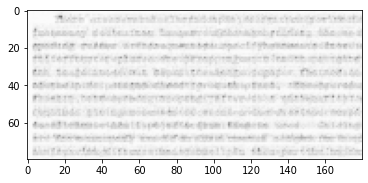

Test: [ 1 / 15 ] Loss: 0.04529890790581703
Test: [ 2 / 15 ] Loss: 0.04599989950656891
Test: [ 3 / 15 ] Loss: 0.044569049030542374
Test: [ 4 / 15 ] Loss: 0.04554414376616478
Test: [ 5 / 15 ] Loss: 0.044882722198963165
Test: [ 6 / 15 ] Loss: 0.045567065477371216
Test: [ 7 / 15 ] Loss: 0.017555879428982735
Test: [ 8 / 15 ] Loss: 0.050078075379133224
Test: [ 9 / 15 ] Loss: 0.05057015269994736
Test: [ 10 / 15 ] Loss: 0.05048258602619171
Test: [ 11 / 15 ] Loss: 0.05116422846913338
Test: [ 12 / 15 ] Loss: 0.04954279586672783
Test: [ 13 / 15 ] Loss: 0.050547681748867035
Test: [ 14 / 15 ] Loss: 0.04999074339866638
Test: [ 15 / 15 ] Loss: 0.017297254875302315
         Fold:  0 Test avg Loss: 0.04393941238522529
1
Fold:  1 Epoch: [ 1 / 20 ] Loss: 0.07138623740495176
Fold:  1 Epoch: [ 2 / 20 ] Loss: 0.0138570381321244
Fold:  1 Epoch: [ 3 / 20 ] Loss: 0.008297210744550832
Fold:  1 Epoch: [ 4 / 20 ] Loss: 0.005965891182278247
Fold:  1 Epoch: [ 5 / 20 ] Loss: 0.005172634962224221
Fold:  1 Epoch: [ 6 

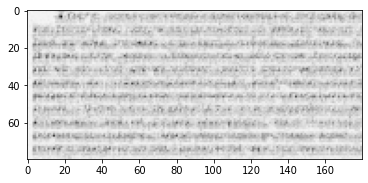

Test: [ 16 / 15 ] Loss: 0.03627749904990196
Test: [ 17 / 15 ] Loss: 0.03252265974879265
Test: [ 18 / 15 ] Loss: 0.03333177790045738
Test: [ 19 / 15 ] Loss: 0.03159521520137787
Test: [ 20 / 15 ] Loss: 0.03232825547456741
Test: [ 21 / 15 ] Loss: 0.033668532967567444
Test: [ 22 / 15 ] Loss: 0.03325270861387253
Test: [ 23 / 15 ] Loss: 0.03349310904741287
Test: [ 24 / 15 ] Loss: 0.034075722098350525
Test: [ 25 / 15 ] Loss: 0.028997307643294334
Test: [ 26 / 15 ] Loss: 0.029045237228274345
Test: [ 27 / 15 ] Loss: 0.027665721252560616
Test: [ 28 / 15 ] Loss: 0.027649665251374245
Test: [ 29 / 15 ] Loss: 0.02370484359562397
Test: [ 30 / 15 ] Loss: 0.030357874929904938
         Fold:  1 Test avg Loss: 0.031197742000222205
1
Fold:  2 Epoch: [ 1 / 20 ] Loss: 0.0739077693356793
Fold:  2 Epoch: [ 2 / 20 ] Loss: 0.013905524633564922
Fold:  2 Epoch: [ 3 / 20 ] Loss: 0.008551548391542077
Fold:  2 Epoch: [ 4 / 20 ] Loss: 0.006517184049959561
Fold:  2 Epoch: [ 5 / 20 ] Loss: 0.005719618529601153
Fold:  2 

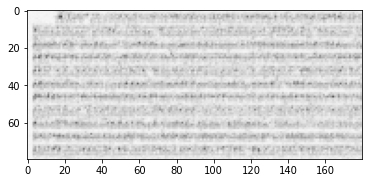

Test: [ 31 / 15 ] Loss: 0.031001849099993706
Test: [ 32 / 15 ] Loss: 0.03131764754652977
Test: [ 33 / 15 ] Loss: 0.03137170523405075
Test: [ 34 / 15 ] Loss: 0.025302445515990257
Test: [ 35 / 15 ] Loss: 0.02525300346314907
Test: [ 36 / 15 ] Loss: 0.02646484784781933
Test: [ 37 / 15 ] Loss: 0.02107391133904457
Test: [ 38 / 15 ] Loss: 0.02626129426062107
Test: [ 39 / 15 ] Loss: 0.029988477006554604
Test: [ 40 / 15 ] Loss: 0.028078923001885414
Test: [ 41 / 15 ] Loss: 0.030389226973056793
Test: [ 42 / 15 ] Loss: 0.03027389943599701
Test: [ 43 / 15 ] Loss: 0.025586532428860664
Test: [ 44 / 15 ] Loss: 0.025587549433112144
Test: [ 45 / 15 ] Loss: 0.026199402287602425
         Fold:  2 Test avg Loss: 0.027610047658284505
1
Fold:  3 Epoch: [ 1 / 20 ] Loss: 0.07196143728702567
Fold:  3 Epoch: [ 2 / 20 ] Loss: 0.013906854576640582
Fold:  3 Epoch: [ 3 / 20 ] Loss: 0.008409805333564294
Fold:  3 Epoch: [ 4 / 20 ] Loss: 0.0063551580786069695
Fold:  3 Epoch: [ 5 / 20 ] Loss: 0.005859085803403873
Fold: 

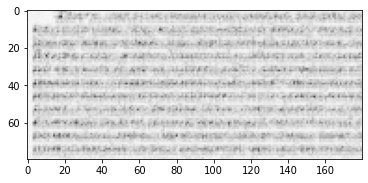

Test: [ 46 / 15 ] Loss: 0.03006136044859886
Test: [ 47 / 15 ] Loss: 0.03443112596869469
Test: [ 48 / 15 ] Loss: 0.033426206558942795
Test: [ 49 / 15 ] Loss: 0.03946508467197418
Test: [ 50 / 15 ] Loss: 0.03895007446408272
Test: [ 51 / 15 ] Loss: 0.024098994210362434
Test: [ 52 / 15 ] Loss: 0.03775104135274887
Test: [ 53 / 15 ] Loss: 0.03775549307465553
Test: [ 54 / 15 ] Loss: 0.036939430981874466
Test: [ 55 / 15 ] Loss: 0.03741583600640297
Test: [ 56 / 15 ] Loss: 0.039415955543518066
Test: [ 57 / 15 ] Loss: 0.03963473066687584
Test: [ 58 / 15 ] Loss: 0.04274472966790199
Test: [ 59 / 15 ] Loss: 0.023892125114798546
Test: [ 60 / 15 ] Loss: 0.04358690232038498
         Fold:  3 Test avg Loss: 0.035971272736787796
1
Fold:  4 Epoch: [ 1 / 20 ] Loss: 0.07159722746851352
Fold:  4 Epoch: [ 2 / 20 ] Loss: 0.013646433778250446
Fold:  4 Epoch: [ 3 / 20 ] Loss: 0.008349728703689881
Fold:  4 Epoch: [ 4 / 20 ] Loss: 0.006092197451597223
Fold:  4 Epoch: [ 5 / 20 ] Loss: 0.005097938493753855
Fold:  4 E

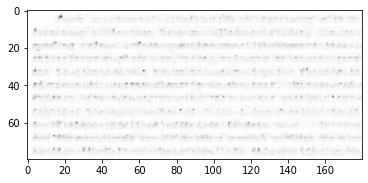

Test: [ 61 / 14 ] Loss: 0.046215180307626724
Test: [ 62 / 14 ] Loss: 0.04485788941383362
Test: [ 63 / 14 ] Loss: 0.04714253544807434
Test: [ 64 / 14 ] Loss: 0.04596669599413872
Test: [ 65 / 14 ] Loss: 0.04527507349848747
Test: [ 66 / 14 ] Loss: 0.045045699924230576
Test: [ 67 / 14 ] Loss: 0.046233586966991425
Test: [ 68 / 14 ] Loss: 0.045054033398628235
Test: [ 69 / 14 ] Loss: 0.03378038480877876
Test: [ 70 / 14 ] Loss: 0.03339414298534393
Test: [ 71 / 14 ] Loss: 0.03432980179786682
Test: [ 72 / 14 ] Loss: 0.03405555710196495
Test: [ 73 / 14 ] Loss: 0.025307023897767067
Test: [ 74 / 14 ] Loss: 0.025968050584197044
         Fold:  4 Test avg Loss: 0.039473261151994975
1
Fold:  5 Epoch: [ 1 / 20 ] Loss: 0.07246214430779219
Fold:  5 Epoch: [ 2 / 20 ] Loss: 0.013928563745978933
Fold:  5 Epoch: [ 3 / 20 ] Loss: 0.008490233448071358
Fold:  5 Epoch: [ 4 / 20 ] Loss: 0.006769874077648497
Fold:  5 Epoch: [ 5 / 20 ] Loss: 0.005835621932951304
Fold:  5 Epoch: [ 6 / 20 ] Loss: 0.005482937122145906

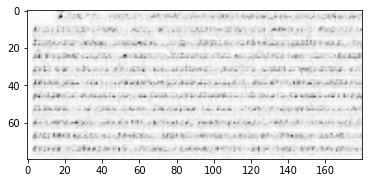

Test: [ 75 / 14 ] Loss: 0.03254222869873047
Test: [ 76 / 14 ] Loss: 0.03296511247754097
Test: [ 77 / 14 ] Loss: 0.033075813204050064
Test: [ 78 / 14 ] Loss: 0.03333880752325058
Test: [ 79 / 14 ] Loss: 0.03303608298301697
Test: [ 80 / 14 ] Loss: 0.03312692791223526
Test: [ 81 / 14 ] Loss: 0.03325379639863968
Test: [ 82 / 14 ] Loss: 0.027696585282683372
Test: [ 83 / 14 ] Loss: 0.03334428742527962
Test: [ 84 / 14 ] Loss: 0.032796334475278854
Test: [ 85 / 14 ] Loss: 0.033208489418029785
Test: [ 86 / 14 ] Loss: 0.03338296711444855
Test: [ 87 / 14 ] Loss: 0.033542267978191376
Test: [ 88 / 14 ] Loss: 0.028045542538166046
         Fold:  5 Test avg Loss: 0.0323825173878244
1
Fold:  6 Epoch: [ 1 / 20 ] Loss: 0.07193733177219445
Fold:  6 Epoch: [ 2 / 20 ] Loss: 0.014157003078323144
Fold:  6 Epoch: [ 3 / 20 ] Loss: 0.00920034148133336
Fold:  6 Epoch: [ 4 / 20 ] Loss: 0.006552500768493001
Fold:  6 Epoch: [ 5 / 20 ] Loss: 0.005819659939465614
Fold:  6 Epoch: [ 6 / 20 ] Loss: 0.004788081607041069
Fo

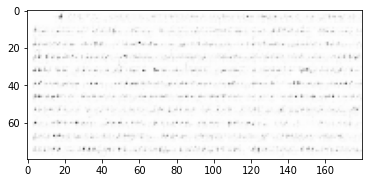

Test: [ 89 / 14 ] Loss: 0.03132748603820801
Test: [ 90 / 14 ] Loss: 0.0401686392724514
Test: [ 91 / 14 ] Loss: 0.03696843609213829
Test: [ 92 / 14 ] Loss: 0.04051293432712555
Test: [ 93 / 14 ] Loss: 0.02860557660460472
Test: [ 94 / 14 ] Loss: 0.03754006698727608
Test: [ 95 / 14 ] Loss: 0.03942294791340828
Test: [ 96 / 14 ] Loss: 0.03717034310102463
Test: [ 97 / 14 ] Loss: 0.04040246084332466
Test: [ 98 / 14 ] Loss: 0.0374462865293026
Test: [ 99 / 14 ] Loss: 0.04149312898516655
Test: [ 100 / 14 ] Loss: 0.03788561746478081
Test: [ 101 / 14 ] Loss: 0.041878096759319305
Test: [ 102 / 14 ] Loss: 0.0384957417845726
         Fold:  6 Test avg Loss: 0.03780841162162168
1
Fold:  7 Epoch: [ 1 / 20 ] Loss: 0.07108364891833983
Fold:  7 Epoch: [ 2 / 20 ] Loss: 0.014246962291116898
Fold:  7 Epoch: [ 3 / 20 ] Loss: 0.008646340701633538
Fold:  7 Epoch: [ 4 / 20 ] Loss: 0.006762743812914078
Fold:  7 Epoch: [ 5 / 20 ] Loss: 0.006313775236216875
Fold:  7 Epoch: [ 6 / 20 ] Loss: 0.0060871675503082
Fold:  

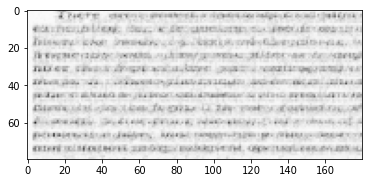

Test: [ 103 / 14 ] Loss: 0.039344608783721924
Test: [ 104 / 14 ] Loss: 0.03641447424888611
Test: [ 105 / 14 ] Loss: 0.03782771900296211
Test: [ 106 / 14 ] Loss: 0.03575693815946579
Test: [ 107 / 14 ] Loss: 0.029079392552375793
Test: [ 108 / 14 ] Loss: 0.034880347549915314
Test: [ 109 / 14 ] Loss: 0.034019988030195236
Test: [ 110 / 14 ] Loss: 0.03520294651389122
Test: [ 111 / 14 ] Loss: 0.03399558365345001
Test: [ 112 / 14 ] Loss: 0.03662528097629547
Test: [ 113 / 14 ] Loss: 0.03460537642240524
Test: [ 114 / 14 ] Loss: 0.035112492740154266
Test: [ 115 / 14 ] Loss: 0.027921199798583984
Test: [ 116 / 14 ] Loss: 0.033926308155059814
         Fold:  7 Test avg Loss: 0.034622332613383024
1
Fold:  8 Epoch: [ 1 / 20 ] Loss: 0.07192935969393988
Fold:  8 Epoch: [ 2 / 20 ] Loss: 0.013406517206189725
Fold:  8 Epoch: [ 3 / 20 ] Loss: 0.00856993229677662
Fold:  8 Epoch: [ 4 / 20 ] Loss: 0.007206159187122607
Fold:  8 Epoch: [ 5 / 20 ] Loss: 0.005782772385730193
Fold:  8 Epoch: [ 6 / 20 ] Loss: 0.0047

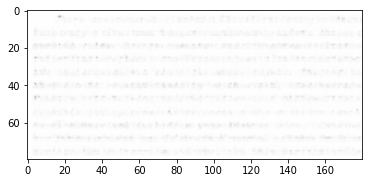

Test: [ 117 / 14 ] Loss: 0.03827371820807457
Test: [ 118 / 14 ] Loss: 0.036558669060468674
Test: [ 119 / 14 ] Loss: 0.03868860378861427
Test: [ 120 / 14 ] Loss: 0.03737973794341087
Test: [ 121 / 14 ] Loss: 0.03706023842096329
Test: [ 122 / 14 ] Loss: 0.03666837885975838
Test: [ 123 / 14 ] Loss: 0.0381305031478405
Test: [ 124 / 14 ] Loss: 0.03685912489891052
Test: [ 125 / 14 ] Loss: 0.03051895461976528
Test: [ 126 / 14 ] Loss: 0.03164990246295929
Test: [ 127 / 14 ] Loss: 0.030630620196461678
Test: [ 128 / 14 ] Loss: 0.03176594525575638
Test: [ 129 / 14 ] Loss: 0.028624361380934715
Test: [ 130 / 14 ] Loss: 0.030249256640672684
         Fold:  8 Test avg Loss: 0.03450414392032793
1
Fold:  9 Epoch: [ 1 / 20 ] Loss: 0.07282227403842485
Fold:  9 Epoch: [ 2 / 20 ] Loss: 0.0131906038400932
Fold:  9 Epoch: [ 3 / 20 ] Loss: 0.008313034436641595
Fold:  9 Epoch: [ 4 / 20 ] Loss: 0.006255225432463564
Fold:  9 Epoch: [ 5 / 20 ] Loss: 0.005043791124167351
Fold:  9 Epoch: [ 6 / 20 ] Loss: 0.0043277149

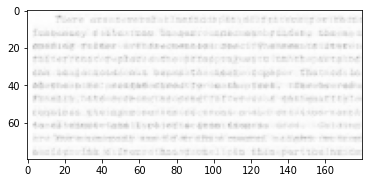

Test: [ 131 / 14 ] Loss: 0.030372735112905502
Test: [ 132 / 14 ] Loss: 0.02935797907412052
Test: [ 133 / 14 ] Loss: 0.030354801565408707
Test: [ 134 / 14 ] Loss: 0.03291581571102142
Test: [ 135 / 14 ] Loss: 0.033701341599226
Test: [ 136 / 14 ] Loss: 0.03299691528081894
Test: [ 137 / 14 ] Loss: 0.021351981908082962
Test: [ 138 / 14 ] Loss: 0.03383063152432442
Test: [ 139 / 14 ] Loss: 0.03263608738780022
Test: [ 140 / 14 ] Loss: 0.03363615274429321
Test: [ 141 / 14 ] Loss: 0.032822370529174805
Test: [ 142 / 14 ] Loss: 0.03365352004766464
Test: [ 143 / 14 ] Loss: 0.04818277806043625
Test: [ 144 / 14 ] Loss: 0.0491832010447979
         Fold:  9 Test avg Loss: 0.033928307970719676
1


In [ ]:
learning_rate = 0.0001
autoencoder = Autoncoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
autoencoder.train()
loss_values = Kfold_t(autoencoder, train_set, train_cleaned_set, 20, loss, optimizer, 10)

How the image should have ended

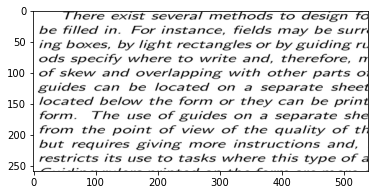

In [ ]:
img = train_cleaned_set[0]
Show_Weight(img)

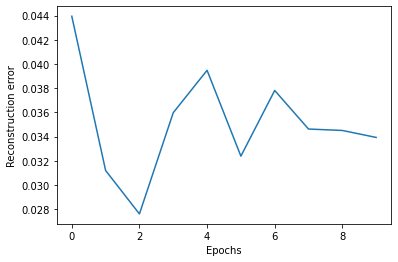

In [ ]:
fig = plt.figure()
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

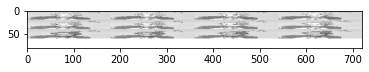

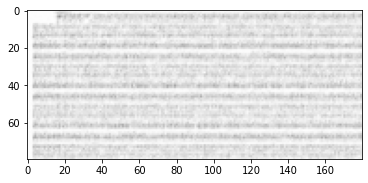

In [ ]:
img_autoencoder(autoencoder_p, 'photo.png')